In [1]:
%load_ext watermark

# Introduction to using PyMC
This notebook provides a quick over view ofusing the PyMC library to perform a Bayesian linear regression on some synthesised data. You can use it as a starting point for more complexe analyses  When running this notebook on Binder you should not use more than about 250 data points. If you set PyMC up on your own computer then it can handle as many data points as you can throw at it (and have the patience for waiting for an answer for).

This note book procedes as follows:
1. Import libraries
2. Synthesise data - linear data with a given slope and intercept. Noise is added to this data
3. Check of data and fit with Ordinary Least Squares
4. Set up Bayesian model and sample to see how it compares to the data
5. Exploration of results

## imports

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pymc as pm
import xarray as xr
import arviz as az
from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator


## data creation

### model:
$y_i=\alpha + \beta\times x_i$

A linear model with a slope $\beta$ and intercept $\alpha$

In [4]:
N = 50 # no. of data points - play with this
# values to generate the demo data from
true_alpha = 4.0
true_beta = 0.5
true_sd = 0.5

# Generate data
x = 10 * np.random.rand(N) # generate N x points in range 0 to 10.
y = true_alpha + true_beta*x # straight line (all data will lie on the line)
y = np.random.normal(y, scale=true_sd) # add random noise to the data. The scale factor sets the width of the nose distribution (check the numpy documentation)


## Data visualisation
Include "true" line and standard linear regression fit

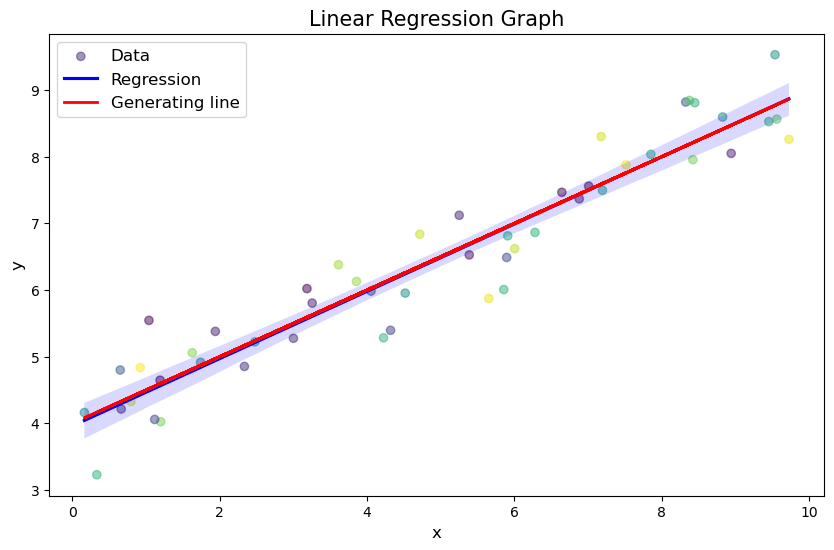

In [5]:
# Plotting the data into a scatter graph, formatting & plotting regression line
colors = np.random.rand(N) # showing off, each data point has a random colour associated with it
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Linear Regression Graph', size = 15)
ax.set_xlabel('x', fontsize = 12)
ax.set_ylabel('y', fontsize = 12)
scatr = plt.scatter(x=x, y=y, c=colors, alpha=0.5, label='Data' ) # Scatter plot of the data
sns.regplot(x=x, y=y, scatter=False, scatter_kws={'alpha':0.1, 'color':'black'}, line_kws={'color':'blue'},label='Regression'); # add regression line to the plot
line, = plt.plot(x,true_alpha + true_beta*x , 'r-', lw=2, label="Generating line") # the true line
# Fitting legend
ax.legend( fontsize = 12);

Notice that the regression line is close to the 'True' line. Explore what happens as you change the number of data points ( you will to change this in the data creation block then re-run this block)

## Bayesian approach

### Linear model with predictor variable (x)

$$ \alpha \sim \textnormal{`a prior'} $$
$$ \beta \sim \textnormal{`a n other prior'}$$
$$ \sigma \sim \textnormal{`y a other prior'}$$
$$ \mu = \alpha + \beta X$$
$$ Y \sim \mathscr{N}(\mu,\sigma) $$

Model describes a linear relationship between X and Y. Slope is $\beta$ and intercept is $\alpha$. These are random variables (hence the '~'). 

$\mu$ is determined ($=$) an expression involving the probabalistic terms $\alpha$ and $\beta$. The noise term $\sigma$ means that the relationship is probablistic rather than deterministic.

### Priors
Priors are a key part of Bayesian analysis. They allow what is known about the properties of the system to be included in the analysis in a principled manner.

$\alpha$ and $\beta$ can take on any real values – use a normal prior for them. For simplicity, will use values for the standard deviations of the distribution. In "real life" it may be better to use something like an inverse gamma distribution for these standard deviations.

$\sigma$ will be a positive number - use a HalfNormal prior (could also use an exponential prior)

Note: Models can be visualised with the PreliZ library. This allows the implications of the priors to be explored. Not covered here.


In [6]:
# first evaluate some start points for the fitting
midY=np.mean(y)
midX=np.mean(x)
slope_start = midY/midX # mean slope - used in prior


with pm.Model() as lin1:
    α = pm.Normal("α", mu=0, sigma=10) # intercept, broad fairly uninformative prior
    β = pm.Normal("β", mu=midY/midX, sigma=10) # slope use average slope as a start value
    σ = pm.HalfCauchy("σ", 5) # prior for the noise - the Half Cauchy is often used when there is no other information to bring in to the model
    μ = pm.Deterministic("μ", α+β*x)
    Ypred = pm.Normal("Ypred", mu=μ, sigma=σ, observed=y)
    inferenceData = pm.sample(draws=4000, tune=1000, chains=4, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2 seconds.


### Look at results
Begin a look at the marginal distributions for α, β, and σ using the ARViz library - this is designed to aid the analysis of results from PyMC, Stan, etc.

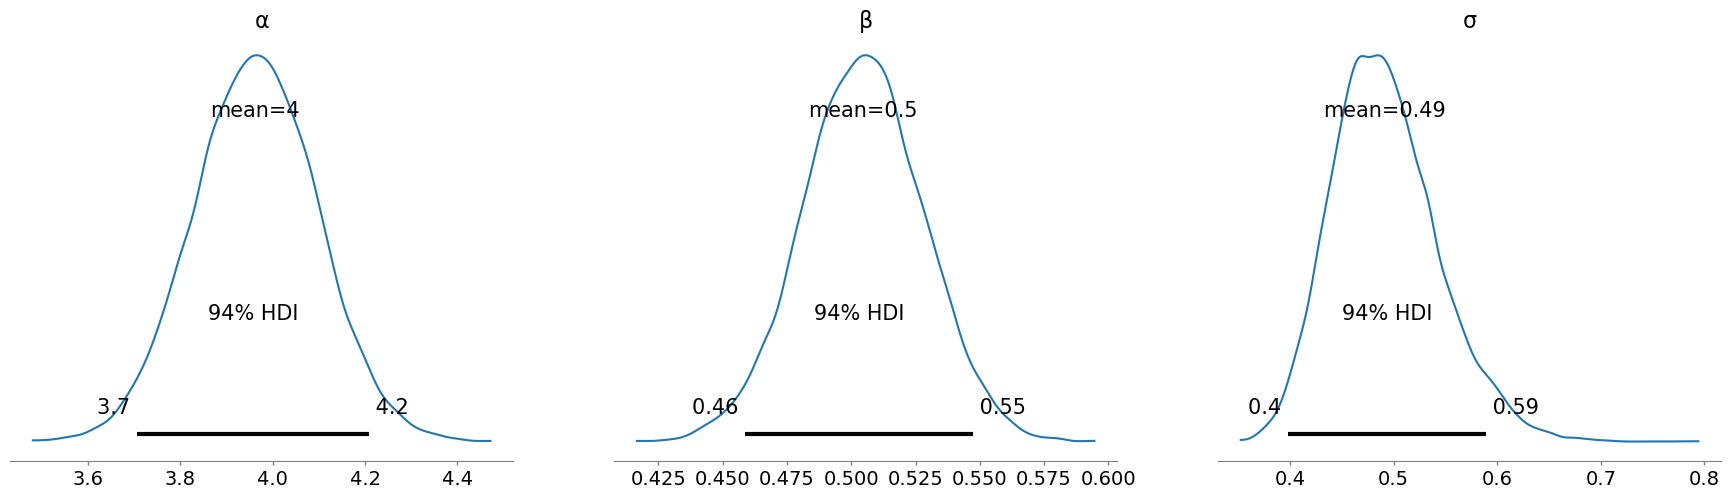

In [7]:
az.plot_posterior(inferenceData, var_names=['~μ']); # note use of ~ to negate outputting mu values

## Interpreting the results

The plots show the most likely values for the parameters. For this linear model we get nice and easy to interpret shapes. The peak values can be related to the results that a classic/frequentist analsys would give. The black lines show the 94% Highest Density Interval. This is a useful version of the confidence interval from frequentist statistics - it gives the range where it is most probable to find the parameter values.

### Exercise
Try playing with the number of samples used in the block that did the fitting. You should find that the curves get simpler/smoother as the number of samples is increased – the computation time will increase with the the number of samples though so you will need to optimise the number of samples for your application. 

#### Visualizing the uncertainty 
The following code block produces these plots:

1. Plot of mean along with 50 samples from posterior
2. Plot of 94% HDI based on all samples

HDI - Highest Denisty Interval: the region(s) in which the probability indicated is located. This is not the same as a confidence interval, but is what many mistake a confidence interval for.

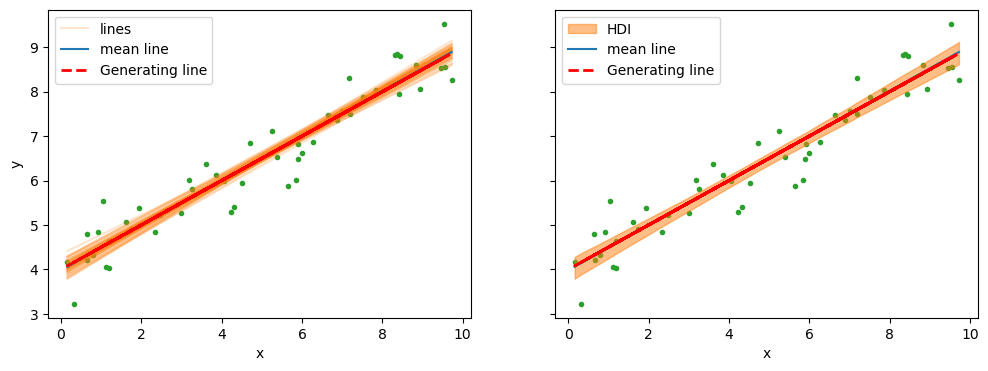

In [8]:
posterior = az.extract(inferenceData, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(np.min(x), np.max(x), 50), dims="plot_id"
)
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
hdi_lines = az.hdi(inferenceData.posterior["μ"]) # highest data interval (minimal credible range)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(x, y, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].plot(x,true_alpha + true_beta*x , 'r--', lw=2, label="Generating line")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend()

axes[1].plot(x, y, "C2.", zorder=-3)
idx = np.argsort(x)
axes[1].fill_between(
    x[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].plot(x,true_alpha + true_beta*x , 'r--', lw=2, label="Generating line")
axes[1].set_xlabel("x")
axes[1].legend();
# to save the output uncomment the next line and addvalid path, filename...
#plt.savefig("path/filename.png")

Note that the 'best' fits are essentially the same as the linear regression results - for Normal errors and uninformative priors they would be exactly the same. 

When there are lots of data points (>200 or so) the mean and generating lines are coincident, but differences appear when the number of reduces - try reducing the number to 25 and running the cells again. 

The Bayesain analysis gives the measures of uncertainty + easy extension to more involved models/distributions.

## Interpretting the posterior predictions

Can use the model to create predictive samples:

In [9]:
pm.sample_posterior_predictive(inferenceData, model=lin1, extend_inferencedata=True, random_seed=123);

Sampling: [Ypred]


These predicted/generated samples can be used to show what the model is producing. The following code shows the predicted data divided up into quantiles around the mean value.

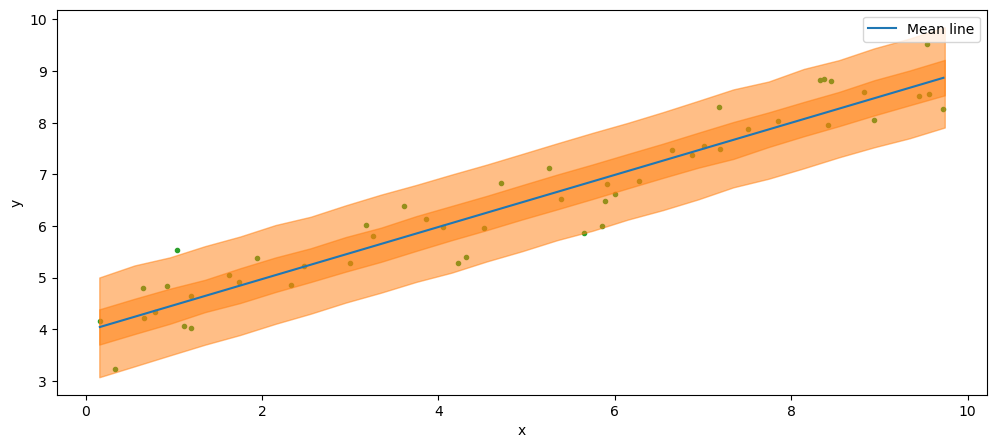

In [10]:
# Plot of the posterior predictions
mean_line = inferenceData.posterior["μ"].mean(("chain", "draw"))
NewxVals = np.random.normal(x, 0.01) # create some new x values (original + noise)
idx = np.argsort(NewxVals) # index (sorted mapping of the x values)
x_pred = np.linspace(NewxVals.min(), NewxVals.max(), 25) # x values in range
# y data based on the quartiles 
y_pred_q = inferenceData.posterior_predictive["Ypred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(NewxVals[idx], y_pred_q[i][idx])(x_pred)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "C2.", zorder=-3) # data
ax.plot(x[idx], mean_line[idx], c="C0", label='Mean line') # line based on mean values

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x_pred, lb, ub, color="C1", alpha=0.5)
# 25-75 -> 50%
# 3-97 -> 94%

# the plot uses transparency so that the 50% range comes out darker than the 94% range

ax.set_xlabel("x")
ax.set_ylabel("y");
ax.legend();

## Next steps

Play with the code - make sure you understand what is going on at each step.

Try changing the distributions and their parametisation. Giving the standard deviations distributions as mentioned above is a good place to start. You could also look at what impact using a student's t distribution has...